# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [5]:
# Create our features
# X = df.drop(columns="loan_status").copy()
X = df.copy()
X.drop("loan_status", axis=1, inplace=True)
X = pd.get_dummies(X)

# Create our target
#y = df[["loan_status"]]
y= df.loc[:, target].copy()

In [6]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [7]:
y

,loan_status
0,low_risk
1,low_risk
2,low_risk
3,low_risk
4,low_risk
...,...
68812,low_risk
68813,low_risk
68814,low_risk
68815,low_risk


In [8]:
Counter(y['loan_status'])

Counter({'low_risk': 68470, 'high_risk': 347})

In [9]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

# Create X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [11]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [12]:
X_train

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
3903,1600.0,0.0881,50.74,35964.0,24.12,0.0,0.0,20.0,0.0,1156.0,...,1,1,1,0,0,1,1,0,1,1
28390,9000.0,0.0756,280.21,41000.0,16.89,1.0,0.0,16.0,0.0,11157.0,...,0,1,0,1,0,1,1,0,1,1
15470,10000.0,0.1033,214.10,112000.0,17.75,0.0,0.0,14.0,0.0,16904.0,...,0,1,0,1,0,1,1,0,1,1
4279,36000.0,0.1033,1167.21,120000.0,19.95,0.0,1.0,13.0,0.0,63248.0,...,1,1,0,1,0,1,1,0,1,1
57514,18000.0,0.0881,570.81,51000.0,19.11,1.0,0.0,16.0,0.0,17586.0,...,0,1,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,8400.0,0.0646,257.30,37992.0,33.16,0.0,0.0,9.0,0.0,7316.0,...,0,1,0,1,1,0,1,0,1,1
20609,30000.0,0.0646,918.93,217000.0,19.56,0.0,2.0,25.0,0.0,142377.0,...,0,1,0,1,1,0,1,0,1,1
21440,20000.0,0.1180,442.88,35000.0,16.19,0.0,0.0,6.0,0.0,273.0,...,0,1,0,1,1,0,0,1,1,1
50057,11625.0,0.1447,273.34,30000.0,18.96,0.0,2.0,10.0,0.0,8237.0,...,0,1,0,1,1,0,1,0,1,1


In [13]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [14]:
# Scale the training and testing data
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [15]:
X_train_scaled

array([[-1.46833559, -0.82153497, -1.49317685, ..., -0.40374336,
         0.        ,  0.        ],
       [-0.7493051 , -1.08086564, -0.69775565, ..., -0.40374336,
         0.        ,  0.        ],
       [-0.65213882, -0.50618887, -0.92691543, ..., -0.40374336,
         0.        ,  0.        ],
       ...,
       [ 0.319524  , -0.201216  , -0.133886  , ...,  2.47682094,
         0.        ,  0.        ],
       [-0.49424361,  0.35271432, -0.72156941, ..., -0.40374336,
         0.        ,  0.        ],
       [ 0.319524  , -0.50618887, -0.18477188, ...,  2.47682094,
         0.        ,  0.        ]])

In [16]:
X_test_scaled

array([[-0.65213882,  0.06433861, -0.49975826, ..., -0.40374336,
         0.        ,  0.        ],
       [-0.62541809,  0.69918009, -0.80025534, ..., -0.40374336,
         0.        ,  0.        ],
       [ 2.26284965, -0.95016298,  2.68802733, ..., -0.40374336,
         0.        ,  0.        ],
       ...,
       [-0.16630741,  0.58092531, -0.4164621 , ..., -0.40374336,
         0.        ,  0.        ],
       [-1.07967046, -0.30287362, -1.03066301, ..., -0.40374336,
         0.        ,  0.        ],
       [ 2.26284965,  0.35271432,  3.10152711, ...,  2.47682094,
         0.        ,  0.        ]])

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [17]:
# Resample the training data with the RandomOversampler
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)
print(Counter(y_resampled['loan_status']))
print()
print(y_resampled.value_counts())

Counter({'low_risk': 51366, 'high_risk': 51366})

loan_status
low_risk       51366
high_risk      51366
dtype: int64


In [18]:
# Train the Logistic Regression model using the resampled data
# Logistic regression using random oversampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [19]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.8377019676944308

In [20]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm, index=["Actual high risk", "Actual low risk"],
                      columns=["Predicted high risk", "Predicted low risk"])

display(cm_df)

,Predicted high risk,Predicted low risk
Actual high risk,84,17
Actual low risk,2673,14431


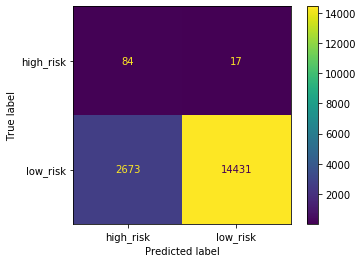

In [21]:
# Display the confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test_scaled, y_test)

In [22]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.83      0.84      0.06      0.84      0.70       101
   low_risk       1.00      0.84      0.83      0.91      0.84      0.70     17104

avg / total       0.99      0.84      0.83      0.91      0.84      0.70     17205



### SMOTE Oversampling

In [23]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE

X_resampled2, y_resampled2 = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(
    X_train_scaled, y_train
)


print(Counter(y_resampled2['loan_status']))
print()
print(y_resampled2.value_counts())

Counter({'low_risk': 51366, 'high_risk': 51366})

loan_status
low_risk       51366
high_risk      51366
dtype: int64


In [24]:
# Train the Logistic Regression model using the resampled data
model2 = LogisticRegression(solver='lbfgs', random_state=1)
model2.fit(X_resampled2, y_resampled2)

LogisticRegression(random_state=1)

In [25]:
# Calculated the balanced accuracy score
y_pred2 = model2.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred2)

0.8388510243681058

In [26]:
# Display the confusion matrix
cm2 = confusion_matrix(y_test, y_pred2)

cm_df2 = pd.DataFrame(cm2, index=["Actual high risk", "Actual low risk"],
                      columns=["Predicted high risk", "Predicted low risk"])

cm_df2

,Predicted high risk,Predicted low risk
Actual high risk,82,19
Actual low risk,2295,14809


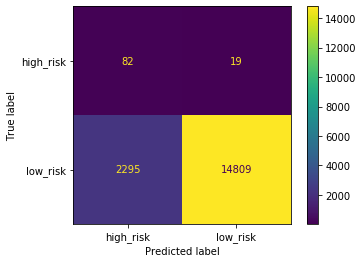

In [27]:
# Display the confusion matrix
plot_confusion_matrix(model2, X_test_scaled, y_test)

In [28]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred2))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.81      0.87      0.07      0.84      0.70       101
   low_risk       1.00      0.87      0.81      0.93      0.84      0.71     17104

avg / total       0.99      0.87      0.81      0.92      0.84      0.71     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classification report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [29]:
# Resample the data using the ClusterCentroids resampler
# Fit the data using `ClusterCentroids` and check the count of each class
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=1)
X_resampled3, y_resampled3 = cc.fit_resample(X_train_scaled, y_train)

Counter(y_resampled3['loan_status'])
print()
print(y_resampled3.value_counts())


loan_status
low_risk       246
high_risk      246
dtype: int64


In [30]:
# Train the Logistic Regression model using the resampled data
# Logistic regression using cluster centroid undersampled dat
model3 = LogisticRegression(solver='lbfgs', random_state=1)
model3.fit(X_resampled3, y_resampled3)

LogisticRegression(random_state=1)

In [31]:
# Calculated the balanced accuracy score
y_pred3 = model3.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred3)

0.8215575767118339

In [32]:
# Display the confusion matrix
cm3 = confusion_matrix(y_test, y_pred3)

cm_df3 = pd.DataFrame(cm3, index=["Actual high risk", "Actual low risk"],
                      columns=["Predicted high risk", "Predicted low risk"])

display(cm_df3)

,Predicted high risk,Predicted low risk
Actual high risk,89,12
Actual low risk,4072,13032


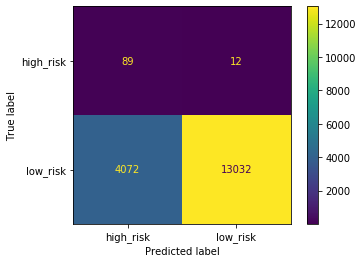

In [33]:
# Display the confusion matrix
plot_confusion_matrix(model3, X_test_scaled, y_test)

In [34]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred3))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.88      0.76      0.04      0.82      0.68       101
   low_risk       1.00      0.76      0.88      0.86      0.82      0.66     17104

avg / total       0.99      0.76      0.88      0.86      0.82      0.66     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classification report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [41]:
# Resample the training data with SMOTEENN
#SMOTEENN combination sampling
from imblearn.combine import SMOTEENN

sm = SMOTEENN(random_state=1)
X_resampled4, y_resampled4 = sm.fit_resample(X_train_scaled, y_train)

Counter(y_resampled4['loan_status'])
print()
print(y_resampled4.value_counts())


loan_status
high_risk      51366
low_risk       47635
dtype: int64


In [42]:
# Train the Logistic Regression model using the resampled data
model4 = LogisticRegression(solver='lbfgs', random_state=1)
model4.fit(X_resampled4, y_resampled4)

LogisticRegression(random_state=1)

In [43]:
# Calculated the balanced accuracy score
y_pred4 = model4.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred4)

0.8388319216626994

In [44]:
# Display the confusion matrix
cm4 = confusion_matrix(y_test, y_pred4)

cm_df4 = pd.DataFrame(cm4, index=["Actual high risk", "Actual low risk"],
                      columns=["Predicted high risk", "Predicted low risk"])

display(cm_df4)

,Predicted high risk,Predicted low risk
Actual high risk,83,18
Actual low risk,2465,14639


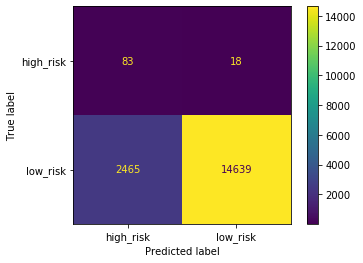

In [45]:
# Display the confusion matrix
plot_confusion_matrix(model4, X_test_scaled, y_test)

In [46]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred4))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.86      0.06      0.84      0.70       101
   low_risk       1.00      0.86      0.82      0.92      0.84      0.71     17104

avg / total       0.99      0.86      0.82      0.92      0.84      0.71     17205



- Which model had the best balanced accuracy score?

**Answer: SMOTE Oversampling had the best balanced accuracy score.**

- Which model had the best recall score?

**Answer: SMOTE Oversampling had the best recall score.**

- Which model had the best geometric mean score?

**Answer: Naive Random Oversampling, SMOTE Oversampling, SMOTEENN Combination (Over and Under) Sampling had the best geometric mean score 0.84**

**Overall, based on F1-score(overall accuracy measure equivalent to the harmonic mean of the precision and recall, 2\*(Precision\*Recall)/(Precision+Recall)) which is a good summary metric for comparing one model's performance to another, SMOTE Oversampling algorithm resulted in the best performance compared to the other sampling algorithms above.**